### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from scipy.stats import binned_statistic,zscore, pearsonr, sem, ttest_1samp
import seaborn as sns
import json
import neurogym as ngym
from tqdm import tqdm
import sys
sys.path.append("../helpers/")

import low_rank_helpers as lr
import importlib
importlib.reload(lr)

import clustering 
from my_vanilla_lowRankRNN import *
import RW_task as task
import scipy.stats as sts

#sns.set_style("ticks")
plt.rcParams.update({'font.size': 10})
sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})

In [3]:

def plot_traj(x,y,color='gray',size=1):

    plt.plot(x,y,color=color,lw=3)
    # plot line from -2 to -1 point
    #plt.arrow(x[-2],y[-2],x[-1] - x[-2],y[-1] - y[-2],head_width=size,head_length=size,color=color,lw=1)
    plt.plot(x[4],y[4],"o",color=color,ms=10)

def torch_sem(a):
  return torch.std(a)/np.sqrt(len(a))
  

### set up / load task

In [4]:
device = 'cpu'
envid = 'mycontext'
envid = 'mycontext_no_input_training'
modelpath = get_modelpath(envid)

dt = 25
n_trials_seq = 10
envid = 'mycontext_no_input_training'
envid = 'mycontext_no_input_training_small'

# noise in stimulus
env_kwargs = {'dt': dt, 'sigma': 1}
env = task.GoNogoContextDecisionMaking(**env_kwargs) 
trial_dur = sum(list(env.timing.values())) // dt

modelpath = get_modelpath(envid)
config = {
    'dt': dt,
    'hidden_size': 3000,
    'lr': 1e-3,
    'batch_size': 16,
    'seq_len': trial_dur * n_trials_seq,
    'trial_dur': trial_dur,
    'n_trials_seq': n_trials_seq,
    'envid': envid,
    'noise': 0.5,
}

config['hidden_size'] = 3000 #4998
config['env_kwargs'] = env_kwargs

#Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)
    
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']
env =task.GoNogoContextDecisionMaking(**env_kwargs) 
env.timing = task.infer_test_timing(env)
env.reset(no_step=True)

# create trial generator to train network
dataset = ngym.Dataset(
    env, env_kwargs=env_kwargs, batch_size=config['batch_size'],
    seq_len=config['seq_len'])

env = dataset.env
output_size = dataset.env.action_space.n
input_size = env.observation_space.shape[0]

print(config)
print(output_size)


net = load_net(envid=envid,env=env).to(device)
net.rnn.device = device


#z, act, obs, gts, choices = test_net(net,env,device=device,num_trials=200)


{'dt': 25, 'hidden_size': 3000, 'lr': 0.001, 'batch_size': 16, 'seq_len': 140, 'trial_dur': 14, 'n_trials_seq': 10, 'envid': 'mycontext_no_input_training_small', 'noise': 0.5, 'env_kwargs': {'dt': 25, 'sigma': 1}}
1


### sanity check 

../helpers/my_vanilla_lowRankRNN.py:94: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  W = torch.outer(self.m,self.n.T)
../helpers/my_vanilla_lowRankRNN.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  act = torch.tensor(activity).cpu().type(torch.float)


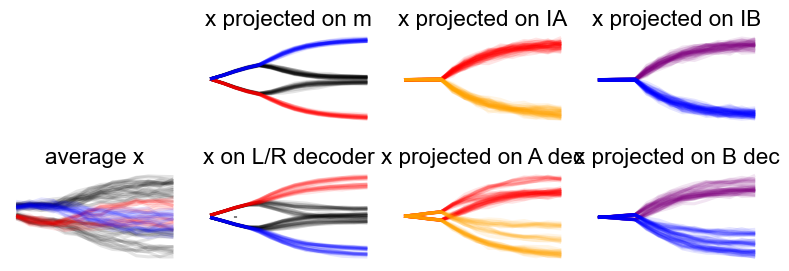

In [5]:
def plot_trials_colors(act,labels,axis=False):
  plt.plot(act[labels == 0,:].T,"k",alpha=0.1)
  plt.plot(act[labels == -1,:].T,"r",alpha=0.1)
  plt.plot(act[labels == 1,:].T,"b",alpha=0.1)
  if not axis:
    plt.axis("off")

z, act, obs, gts, choices = test_net(net,env,device=device)

tf = torch.tanh
phi_X = tf(act)
stim_idx = np.mean(obs[:,5:8,:],1)

ctx = torch.mean(act[obs[:,0,-1] == 1,0,:],0) - torch.mean(act[obs[:,0,-2] == 1,0,:],0)
lr_dec = torch.mean(act[gts == -1,-1,:],0) - torch.mean(act[gts == 1,-1,:],0)
lr_dec_or = lr.gram_schmidt_1(lr_dec,[ctx])

ia_dec = torch.mean(torch.mean(act[stim_idx[:,0] > 0,4:9,:],1),0) - torch.mean(torch.mean(act[stim_idx[:,0] < 0,4:9,:],1),0)
ib_dec =  torch.mean(torch.mean(act[stim_idx[:,1] > 0,4:9,:],1),0) -  torch.mean(torch.mean(act[stim_idx[:,1] < 0,4:9,:],1),0)


IA = torch.squeeze(net.rnn.IA.detach().cpu())
IB = torch.squeeze(net.rnn.IB.detach().cpu())


fig = plt.figure(dpi=100,figsize=(8,3))
fig.patch.set_facecolor('white')



plt.subplot(2,4,2)
plt.title("x projected on m")
m_a = (act @ net.rnn.m.detach().cpu())

plot_trials_colors(m_a,gts)
plt.plot()


plt.subplot(2,4,3)
plt.title("x projected on IA")
cta = (act @ IA)
plt.plot(cta[stim_idx[:,0] > 0,:].T,color="red",alpha=0.1)
plt.plot(cta[stim_idx[:,0] < 0,:].T,color="orange",alpha=0.1)
plt.axis("off")

plt.subplot(2,4,4)
plt.title("x projected on IB")
cta = (act @ IB)
plt.plot(cta[stim_idx[:,1] > 0,:].T,color="purple",alpha=0.1)
plt.plot(cta[stim_idx[:,1] < 0,:].T,color="blue",alpha=0.1)
plt.axis("off")

plt.subplot(2,4,5)
plt.title(r"average x")
z = torch.mean(act,2)
plot_trials_colors(z,gts)

plt.subplot(2,4,6)
plt.title(r"x on L/R decoder")
cta = (act @ lr_dec)
plot_trials_colors(cta,gts)
plt.plot([2,2],[-500,500],"k--")

plt.subplot(2,4,7)
plt.title("x projected on A dec")
cta = (act @ ia_dec)
plt.plot(cta[stim_idx[:,0] > 0,:].T,color="red",alpha=0.1)
plt.plot(cta[stim_idx[:,0] < 0,:].T,color="orange",alpha=0.1)
plt.axis("off")

plt.subplot(2,4,8)
plt.title("x projected on B dec")
cta = (act @ ib_dec)
plt.plot(cta[stim_idx[:,1] > 0,:].T,color="purple",alpha=0.1)
plt.plot(cta[stim_idx[:,1] < 0,:].T,color="blue",alpha=0.1)
plt.axis("off")


plt.tight_layout()



### plot trajectory of sensory and seleciton 

Text(0.5, 0, 'sensory')

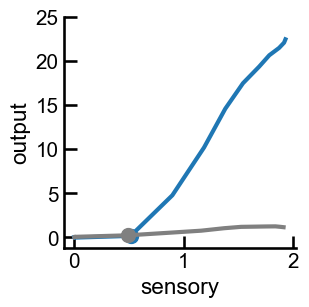

In [6]:
plt.figure(figsize=(3,3))
vs = make_vecs(net).T

for i in range(1):
  z, act, obs, gts, choices = test_net(net,env,device=device,num_trials=200)
  N=config['hidden_size']
  IA = vs[:,3]
  IB =vs[:,4]
  m =vs[:,1]

  m_act = (act @ m) / (np.linalg.norm(m)**2)
  IA_act = (act @ IA) / (np.linalg.norm(IA)**2)
  IB_act = (act @ IB)/ (np.linalg.norm(IB)**2)

  idx_low_A = (obs[:,-1,0]<0) & (obs[:,0,-1] ==0)
  idx_high_A = (obs[:,-1,0]>0) & (obs[:,0,-1] ==0)


  idx_low_B = (obs[:,-1,0]<0) & (obs[:,0,-1] ==1)
  idx_high_B = (obs[:,-1,0]>0) & (obs[:,0,-1] ==1)

  # on m
  m_go_A =torch.mean(m_act[idx_low_A,:],0)
  m_nogo_A =torch.mean(m_act[idx_high_A,:],0)

  m_go_B =torch.mean(m_act[idx_low_B,:],0)
  m_nogo_B =torch.mean(m_act[idx_high_B,:],0)

  # on A
  IA_go_A =-torch.mean(IA_act[idx_low_A,:],0)
  IA_nogo_A =-torch.mean(IA_act[idx_high_A,:],0)

  IA_go_B =-torch.mean(IA_act[idx_low_B,:],0)
  IA_nogo_B =-torch.mean(IA_act[idx_high_B,:],0)

  #plt.plot(IA_go_A - IA_nogo_A,m_go_A - m_nogo_A,color='royalblue')
  plot_traj(IA_go_A - IA_nogo_A,m_go_A - m_nogo_A,color='#1f77b4',size=0.3)


  #plt.plot(IA_go_B - IA_nogo_B,m_go_B - m_nogo_B,'gray')
  plot_traj(IA_go_B - IA_nogo_B,m_go_B - m_nogo_B,'gray',size=0.3)
  sns.despine()

plt.yticks(range(0,30,5))
plt.xticks(range(3))
plt.ylabel('output')
plt.xlabel('sensory')

# plt.savefig('/content/drive/MyDrive/Neuro/postdoc - ENS/GNT/figures/paper/Fig2_sensory_decision_axes.svg')



### infer populations

In [7]:
n_comp = 3
#labels, model = clustering.gmm_fit(np.array(vs), n_components=n_comp,algo='bayes',mean_precision_prior=1e40,weight_concentration_prior=1e50,n_init=50, random_state=2020)
labels, model = clustering.gmm_fit(np.array(vs), n_components=n_comp,algo='bayes', weight_concentration_prior=1e50, random_state=2020)

z, act, obs, gts, choices = test_net(net,env,device=device,num_trials=100)

stim_idx = np.mean(obs[:,5:8,:],1)
ctx_idx = obs[:,0,-2]
ctx_idx = np.array(ctx_idx > 0.5,dtype=np.int)


data = np.abs(tf(act))

ctx = ctx_idx > 0
pre_stim_ctx1 = torch.mean(torch.mean(data[ctx,:3,:],1),0)
pre_stim_ctx2 = torch.mean(torch.mean(data[~ctx,:3,:],1),0)

pre_stim_ctx_pop0 = pre_stim_ctx1[labels==0] - pre_stim_ctx2[labels==0]
pre_stim_ctx_pop1 = pre_stim_ctx1[labels==1] - pre_stim_ctx2[labels==1]
pre_stim_ctx_pop2 = pre_stim_ctx1[labels==2] - pre_stim_ctx2[labels==2]


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_21434/2316721841.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctx_idx = np.array(ctx_idx > 0.5,dtype=np.int)


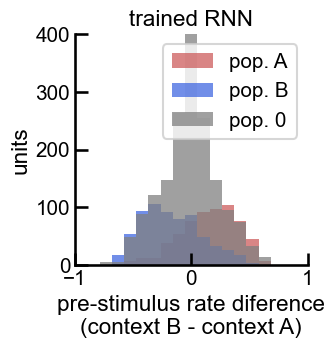

In [8]:
plt.figure(figsize=(3,3))
plt.hist(pre_stim_ctx1[labels==2] - pre_stim_ctx2[labels==2],bins=np.linspace(-1,1,20),alpha=0.75,color="indianred",label="pop. A")
plt.hist(pre_stim_ctx1[labels==0] - pre_stim_ctx2[labels==0],bins=np.linspace(-1,1,20),alpha=0.75,color="royalblue",label="pop. B")
plt.hist(pre_stim_ctx1[labels==1] - pre_stim_ctx2[labels==1],bins=np.linspace(-1,1,20),alpha=0.75,color="gray",label="pop. 0")

plt.legend()
plt.xlabel("pre-stimulus rate diference\n(context B - context A)")
plt.ylabel("units")
plt.title("trained RNN")
plt.xlim(-1,1)
plt.ylim(0,400)
sns.despine()
plt.savefig('figures/sup_trained_pops.svg')


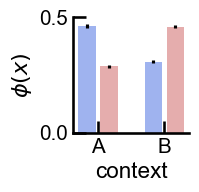

In [9]:
plt.figure(figsize=(1.5,1.5))
pop_A_0 = torch.mean(pre_stim_ctx1[labels==2])
pop_A_1 = torch.mean(pre_stim_ctx2[labels==2])

pop_B_0 = torch.mean(pre_stim_ctx1[labels==0])
pop_B_1 = torch.mean(pre_stim_ctx2[labels==0])

s_pop_A_0 =  torch.std(pre_stim_ctx1[labels==2])/np.sqrt(np.sum(labels==2))
s_pop_A_1 = torch.std(pre_stim_ctx2[labels==2])/np.sqrt(np.sum(labels==2))

s_pop_B_0 = torch.std(pre_stim_ctx1[labels==0])/np.sqrt(np.sum(labels==0))
s_pop_B_1 = torch.std(pre_stim_ctx2[labels==0])/np.sqrt(np.sum(labels==0))

plt.bar([0,1,3,4],[pop_A_0,pop_B_0,pop_A_1,pop_B_1],color=["royalblue", "indianred", "royalblue", "indianred"],alpha=0.5)
plt.errorbar([0,1,3,4],[pop_A_0,pop_B_0,pop_A_1,pop_B_1],[s_pop_A_0,s_pop_B_0,s_pop_A_1,s_pop_B_1],ls='none',color="black") 

plt.ylim(0,0.5)
plt.yticks([0,0.5])
plt.xticks([0.5,3.5],["A","B"])
plt.xlabel("context")
plt.ylabel(r"$\phi(x)$")
sns.despine()

plt.savefig('figures/sup_trained_pops_bar.svg')


## gain modulation

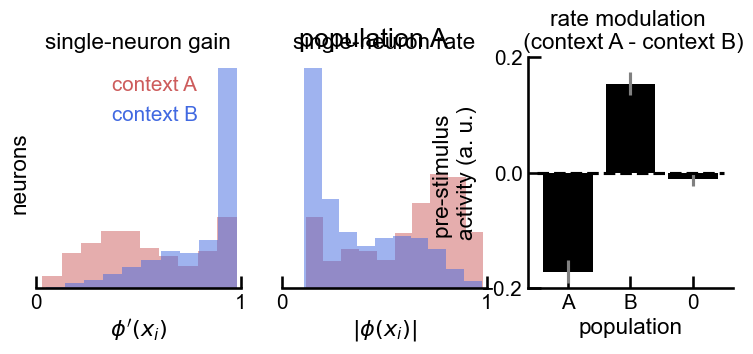

In [10]:
def tanh_prime(x):
    t=np.tanh(x)
    dt=1-t**2
    return dt

labels_a = labels==0
labels_b = labels==2
labels_0 = labels==1

gain_modulation_ctxA = torch.mean(tanh_prime(act)[obs[:,0,-1] == 1,2,:],0).numpy() 
gain_modulation_ctxB = torch.mean(tanh_prime(act)[obs[:,0,-2] == 1,2,:],0).numpy()

gain_modulation = gain_modulation_ctxA - gain_modulation_ctxB

rate_modulation_ctxA = torch.mean(np.abs(tf(act))[obs[:,0,-1] == 1,2,:],0).numpy() 
rate_modulation_ctxB = torch.mean(np.abs(tf(act))[obs[:,0,-2] == 1,2,:],0).numpy()

rate_modulation = rate_modulation_ctxA - rate_modulation_ctxB

plt.figure(figsize=(9,3))

ax = plt.subplot(1,3,1)
plt.suptitle('population A')
plt.xlabel(r"$\phi'(x_i)$")
plt.ylabel('neurons')
plt.title('single-neuron gain')
plt.hist(gain_modulation_ctxA[labels_a],color="indianred",density=True,alpha=0.5,label="context A")
plt.hist(gain_modulation_ctxB[labels_a],color="royalblue",density=True,alpha=0.5,label="context B")
#plt.hist(gain_modulation_ctxA[labels_0],color="black",density=True,histtype='step',label="population 0")

leg = plt.legend(frameon=False,loc='best')

plt.xlim(0,1)
plt.yticks([])
plt.xticks([0,1])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

leg.get_texts()[0].set_color("indianred")
leg.get_texts()[1].set_color("royalblue")


for item in leg.legendHandles:
    item.set_visible(False)
  
ax = plt.subplot(1,3,2)
plt.xlabel(r"$|\phi(x_i)|$")
plt.title('single-neuron rate')
plt.hist(rate_modulation_ctxA[labels_a],color="indianred",density=True,alpha=0.5,label="context A")
plt.hist(rate_modulation_ctxB[labels_a],color="royalblue",density=True,alpha=0.5,label="context B")
#plt.hist(rate_modulation_ctxA[labels_0],color="black",density=True,histtype='step',label="population 0")

plt.xticks([0,1])
plt.xlim(0,1)
plt.yticks([])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(1,3,3)
plt.bar([0,2,1],[torch.mean(pre_stim_ctx_pop0),torch.mean(pre_stim_ctx_pop1),torch.mean(pre_stim_ctx_pop2)],color='k')

plt.errorbar([0,2,1],[torch.mean(pre_stim_ctx_pop0),torch.mean(pre_stim_ctx_pop1),torch.mean(pre_stim_ctx_pop2)],
             [2*torch_sem(pre_stim_ctx_pop0),2*torch_sem(pre_stim_ctx_pop1),2*torch_sem(pre_stim_ctx_pop2)],color="gray",fmt=" ")

plt.plot([-.5,2.5],[0,0],'k--')
plt.ylim(-.2,.2)
plt.yticks([-.2,0,.2])
plt.xticks([0,1,2],["A","B","0"])
plt.ylabel("pre-stimulus \nactivity (a. u.)")
plt.title("rate modulation \n (context A - context B)")
plt.xlabel("population")



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# plt.savefig('/content/drive/MyDrive/Neuro/postdoc - ENS/GNT/figures/paper/Fig2_gain.svg')


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_21434/112954202.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gts = torch.tensor(gts)


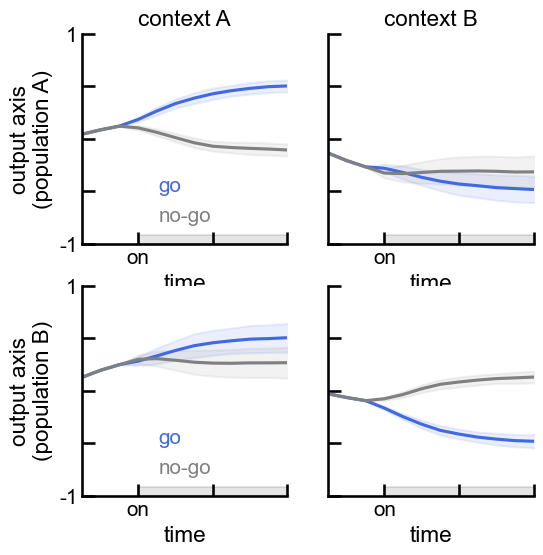

In [46]:
ctx = obs[:,0,-1] > 0.5 #== 1
gts = torch.tensor(gts)
time = range(data.shape[1])
fig = plt.figure(figsize=(9,6))

color_go = ['royalblue','royalblue']
pops = ['A','B']
for pop,p in enumerate([2,0]):
  data = act[:,:,labels == p]

  ctx_dec = torch.mean(data[ctx,0,:],0) - torch.mean(data[~ctx,0,:],0)
  lr_dec = torch.mean(data[gts == -1,-1,:],0) - torch.mean(data[gts == 1,-1,:],0)
  #lr_dec = lr.gram_schmidt_1(lr_dec,[ctx_dec])
  cta = data @ (lr_dec / np.linalg.norm(lr_dec)**2)

  #lr_dec = vs[labels==p,2]/(np.linalg.norm(vs[labels==p,2])**2)
  #cta = data @ (lr_dec)


  plt.subplot(2,3,1+pop*3)
  if pop == 0: plt.title("context A")


  idx_go_A = ((gts == -1) & ctx).bool()
  mu_go_A = torch.mean(cta[idx_go_A,:],0)
  sig_go_A = torch.std(cta[idx_go_A,:],0)
  plt.plot(time,mu_go_A,color=color_go[pop],label="go")
  plt.fill_between(time, mu_go_A+sig_go_A, mu_go_A-sig_go_A,color=color_go[pop], alpha=0.1)
  
  idx_nogo_A = ((gts == 0) & ctx).bool()
  mu_nogo_A = torch.mean(cta[idx_nogo_A,:],0)
  sig_nogo_A = torch.std(cta[idx_nogo_A,:],0)
  plt.plot(time,mu_nogo_A,color="gray",label="no-go")
  plt.fill_between(time, mu_nogo_A+sig_nogo_A, mu_nogo_A-sig_nogo_A,color="gray", alpha=0.1)

  plt.fill_between([4,14],[-1,-1],[-.92,-.92],color="black",alpha=0.1)
  plt.ylim(-1,1)
  #plt.plot(time,np.zeros_like(time),"k--")
  
  plt.xlim(1,12)
  plt.yticks([-1,-0.5,0,0.5,1],[-1,'','','',1])
  plt.xlabel("time")
  plt.ylabel("output axis\n(population %s)" % (pops[pop]))
  plt.xticks([4,8,12],['on','',''])
  l=plt.legend(frameon=False,loc="best")
  l.get_texts()[1].set_color('gray')
  l.get_texts()[0].set_color(color_go[pop])
  for item in l.legendHandles:
      item.set_visible(False)

  plt.subplot(2,3,2+pop*3)
  if pop == 0: plt.title("context B")


  idx_go_B = ((gts == 1) & ~ctx).bool()
  mu_go_B = torch.mean(cta[idx_go_B,:],0)
  sig_go_B = torch.std(cta[idx_go_B,:],0)
  plt.plot(time,mu_go_B,color=color_go[pop])
  plt.fill_between(time, mu_go_B+sig_go_B, mu_go_B-sig_go_B,color=color_go[pop], alpha=0.1)

  idx_nogo_B = ((gts == 0) & ~ctx).bool()
  mu_nogo_B = torch.mean(cta[idx_nogo_B,:],0)
  sig_nogo_B = torch.std(cta[idx_nogo_B,:],0)
  plt.plot(time,mu_nogo_B,color="gray")
  plt.fill_between(time, mu_nogo_B+sig_nogo_B, mu_nogo_B-sig_nogo_B,color="gray", alpha=0.1)

  plt.fill_between([4,14],[-1,-1],[-.92,-.92],color="black",alpha=0.1,label="stimulus period")

  plt.ylim(-1,1)
  plt.xticks([4,8,12],['on','',''])
  #plt.plot(time,np.zeros_like(time),"k--")
  plt.xlim(1,12)
  plt.yticks([-1,-.5,0,.5,1],[])
  plt.xlabel("time")
  sns.despine()
  #plt.tight_layout()



#plt.savefig('/content/drive/MyDrive/Neuro/postdoc - ENS/GNT/figures/paper/Fig2_population.svg')


# gain modulation ratio test

In [ ]:
gain_mod = np.zeros(3)
for pop,p in enumerate([2,0,1]):
  data = act[:,:,labels == p]

  ctx_dec = torch.mean(data[ctx,0,:],0) - torch.mean(data[~ctx,0,:],0)
  lr_dec = torch.mean(data[gts == -1,-1,:],0) - torch.mean(data[gts == 1,-1,:],0)
  cta = data @ (lr_dec / np.linalg.norm(lr_dec)**2)

  idx_go_A = ((gts == -1) & ctx)
  mu_go_A = torch.mean(cta[idx_go_A,:],0)
  sig_go_A = torch.std(cta[idx_go_A,:],0)

  idx_nogo_A = ((gts == 0) & ctx)
  mu_nogo_A = torch.mean(cta[idx_nogo_A,:],0)


  idx_go_B = ((gts == 1) & ~ctx)
  mu_go_B = torch.mean(cta[idx_go_B,:],0)

  idx_nogo_B = ((gts == 0) & ~ctx)
  mu_nogo_B = torch.mean(cta[idx_nogo_B,:],0)


  mod_A = np.abs(mu_go_A[-1] - mu_nogo_A[-1])
  mod_B = np.abs(mu_go_B[-1] - mu_nogo_B[-1])

  gain_mod[pop] = mod_A/mod_B

labels_s = labels.copy()

n_perms = 500
gain_mod_s = np.zeros((n_perms))
for per in range(n_perms):
  np.random.shuffle(labels_s)
  data = act[:,:,labels_s == 0]

  ctx_dec = torch.mean(data[ctx,0,:],0) - torch.mean(data[~ctx,0,:],0)
  lr_dec = torch.mean(data[gts == -1,-1,:],0) - torch.mean(data[gts == 1,-1,:],0)
  cta = data @ (lr_dec / np.linalg.norm(lr_dec)**2)

  # context A

  idx = ((gts == -1) & ctx)
  mu_go_A = torch.mean(cta[idx,:],0)
  
  idx = ((gts == 0) & ctx)
  mu_nogo_A = torch.mean(cta[idx,:],0)

  mod_A = np.abs(mu_go_A[-1] - mu_nogo_A[-1])


  # context B

  idx = ((gts == 1) & ~ctx)
  mu_go_B = torch.mean(cta[idx,:],0)

  idx = ((gts == 0) & ~ctx)
  mu_nogo_B = torch.mean(cta[idx,:],0)

  mod_B = np.abs(mu_go_B[-1] - mu_nogo_B[-1])

  gain_mod_s[per] = mod_A / mod_B


/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_28844/2107540494.py:10: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  mu_go_A = torch.mean(cta[idx_go_A,:],0)
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_28844/2107540494.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  sig_go_A = torch.std(cta[idx_go_A,:],0)
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_28844/2107540494.py:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  mu_nogo_A = torch.mean(cta

Text(0.5, 0, 'context-dependent ratio')

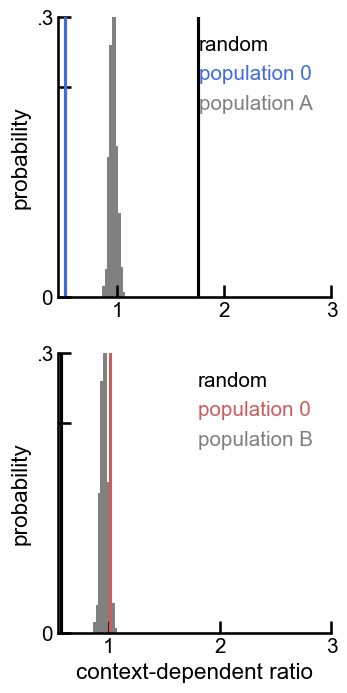

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(2,3,3)

x,b,p = plt.hist(gain_mod_s,color='gray',label='random')
for item in p:
    item.set_height(item.get_height()/sum(x))
plt.ylim(0,0.2)

plt.plot([gain_mod[0],gain_mod[0]],[0,0.2],'k',label='population 0')
plt.plot([gain_mod[1],gain_mod[1]],[0,0.2],label='population A',color='royalblue')
plt.ylabel("probability")
plt.yticks([0,0.15,0.2],["0","",".3"])
sns.despine()
leg = plt.legend(frameon=False)
plt.xticks([1,2,3])

leg.get_texts()[1].set_color("royalblue")
leg.get_texts()[2].set_color("gray")

for item in leg.legendHandles:
    item.set_visible(False)

plt.subplot(2,3,6)

x,b,p = plt.hist(gain_mod_s,color='gray',label='random')
for item in p:
    item.set_height(item.get_height()/sum(x))
plt.ylim(0,0.2)

plt.plot([1/gain_mod[0],1/gain_mod[0]],[0,0.2],'k',label='population 0')
plt.plot([1/gain_mod[2],1/gain_mod[2]],[0,0.2],label='population B',color='indianred')
plt.ylabel("probability")
plt.yticks([0,0.15,0.2],["0","",".3"])
plt.xticks([1,2,3])
leg = plt.legend(frameon=False)
sns.despine()

leg.get_texts()[1].set_color("indianred")
leg.get_texts()[2].set_color("gray")

for item in leg.legendHandles:
    item.set_visible(False)

plt.xlabel('context-dependent ratio')
# plt.savefig('/content/drive/MyDrive/Neuro/postdoc - ENS/GNT/figures/paper/Fig2_ratio_test.svg')
